In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile
import pickle

In [3]:
con = sqlite3.connect('/mydata/final.sqlite')

In [4]:
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con)

In [6]:
final = final.sample(n = 20000)
final.shape

(20000, 12)

In [7]:
l = final['Score']
final = final.drop("Score", axis = 1)

In [8]:
list_clean_text = []
for sent in final['CleanedText'].values:
    list_clean_text.append(sent.split())

In [9]:
# Considering Words with minimum occurence of 5 times
w2v_model = Word2Vec(list_clean_text, min_count = 5, size = 50, workers = 2 )

In [10]:
path = get_tmpfile("word2vec.model")
w2v_model.save("word2vec.model")

In [11]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words occuring more than 5 times", len(w2v_words))
print("sample words", w2v_words[0:50])

number of words occuring more than 5 times 6249
sample words ['one', 'cat', 'prefer', 'fanci', 'feast', 'grill', 'flavor', 'fine', 'minc', 'gravi', 'vet', 'doesnt', 'recommend', 'carbohydr', 'cornstarch', 'compromis', 'like', 'varieti', 'pack', 'vari', 'protein', 'sourc', 'meal', 'understand', 'healthier', 'delight', 'amazon', 'subscrib', 'save', 'automat', 'deliveri', 'reliabl', 'money', 'prevent', 'run', 'food', 'look', 'whole', 'grain', 'wheat', 'flour', 'healthi', 'graham', 'cracker', 'add', 'diet', 'consid', 'check', 'touch', 'honey']


In [12]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)


In [13]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_clean_text: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if (word in w2v_words and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
            
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [19]:
sent_vectors_final = np.asarray(tfidf_sent_vectors)

In [20]:
from tempfile import TemporaryFile
outfile = TemporaryFile()

In [21]:
np.save(outfile, sent_vectors_final)

In [22]:
print(sent_vectors_final.shape)
l.shape

(20000, 50)


(20000,)

In [23]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors_final)
standardized_data.shape

(20000, 50)

In [24]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state = 0, perplexity = 30)
tsne_data = model.fit_transform(standardized_data)

In [25]:
tsne_data = np.vstack((tsne_data.T, l)).T

In [26]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

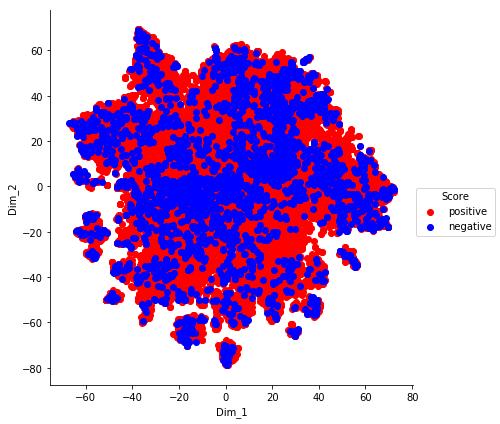

In [27]:
d = dict(color=["r", "b"])
sn.FacetGrid(tsne_df,hue = "Score", hue_kws=d,size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [28]:
model = TSNE(n_components=2, random_state = 0, perplexity = 20, n_iter = 5000)
tsne_data = model.fit_transform(standardized_data)

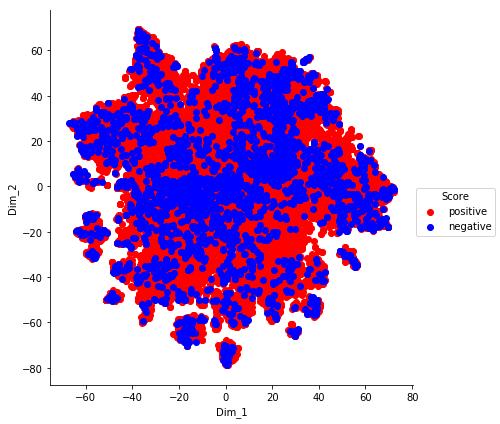

In [29]:
sn.FacetGrid(tsne_df,hue = "Score", hue_kws=d,size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [30]:
tsne_data = model.fit_transform(standardized_data)

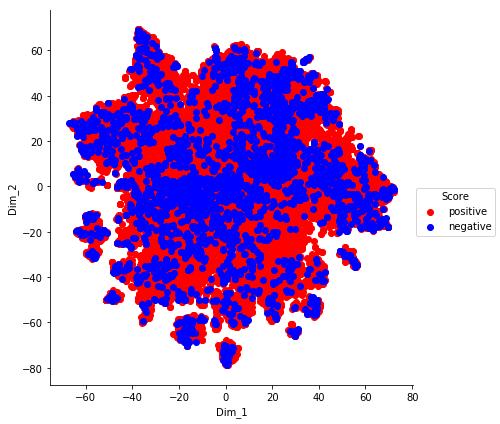

In [31]:
sn.FacetGrid(tsne_df,hue = "Score", hue_kws=d,size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [32]:
model = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 5000)
tsne_data = model.fit_transform(standardized_data)

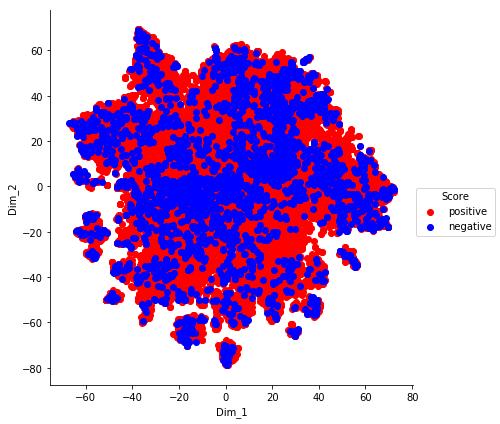

In [33]:
sn.FacetGrid(tsne_df,hue = "Score", hue_kws=d,size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show() 